In [3]:
!pip install thop ptflops

Device: cuda

LOADING USC-HAD DATASET (using USC function)

原数据分析：共12个活动，由14个受试者采集，和DASA数据集不同，这里每个mat文件的长度并不一致，因此需要对每一个mat数据进行滑窗预处理后再合并。
            切分数据集思路可以采取留一法，选取n个受试者数据作为验证集


---------- 采用【留一法】分割验证集，选取的subject为:{13, 14} ----------

Dataset already found at: ./USC-HAD
Loading subject data
       current subject: 【1】
       current subject: 【10】
       current subject: 【11】
       current subject: 【12】
       current subject: 【13】    ----    Validation Data
       current subject: 【14】    ----    Validation Data
       current subject: 【2】
       current subject: 【3】
       current subject: 【4】
       current subject: 【5】
       current subject: 【6】
       current subject: 【7】
       current subject: 【8】
       current subject: 【9】

---------------------------------------------------------------------------------------------------------------------

xtrain shape (N, L, C): (46120, 100, 6)
xtest shape (N, L, C): (9201, 100, 6)
ytrain shape: (46120,)
ytest shape: (9201,)

Loaded Trai

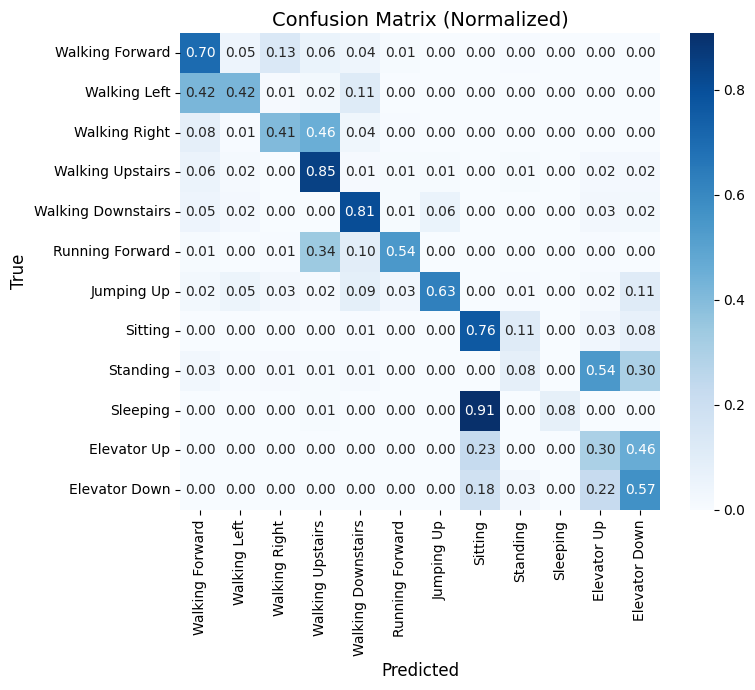

In [10]:
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
from collections import Counter
import scipy.io as scio # USC 함수에 필요
import sys # USC 함수에 필요

# --- 새 로더(USC)에 필요한 라이브러리 추가 ---
import requests
import zipfile
# ------------------------------------

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def plot_confusion_matrix(cm, labels):
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df = pd.DataFrame(cmn, index=labels, columns=labels)
    plt.figure(figsize=(8,7))
    sns.heatmap(df, annot=True, fmt='.2f', cmap='Blues', cbar=True)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix (Normalized)', fontsize=14)
    plt.tight_layout()
    plt.show()

class HARDataset(Dataset):
    def __init__(self, X, y, norm=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

        # 'norm=True'일 경우 (USC 로더가 Z_SCORE=False로 호출된 경우)
        if norm:
            # (N, C, L) 형태이므로 (0, 2) 축으로 계산
            self.mean = self.X.mean(axis=(0,2), keepdims=True)
            self.std = self.X.std(axis=(0,2), keepdims=True) + 1e-8
            self.X = (self.X - self.mean)/self.std
        else:
            # 'norm=False' (USC 로더가 Z_SCORE=True로 호출되어 이미 정규화됨)
            self.mean, self.std = None, None

    def set_stats(self, mean, std):
        # 이 함수는 norm=False일 때 외부 통계를 주입하기 위해 사용됨
        self.mean, self.std = mean, std
        self.X = (self.X - self.mean)/self.std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), int(self.y[i])

# -------------------------------------------------------------------
# ----------------- (시작) 'utils.py' 가상 구현 -----------------
# (제공된 USC.py가 의존하는 함수들을 재구현)
# -------------------------------------------------------------------

def download_dataset(dataset_name, file_url, dataset_dir):
    """
    USC-HAD 데이터셋을 다운로드하고 압축을 풉니다.
    (이전 스크립트의 'download_usc_had' 로직 기반)
    """
    save_dir = os.path.dirname(dataset_dir) # e.g., './'
    zip_path = os.path.join(save_dir, f"{dataset_name}.zip") # e.g., './USC-HAD.zip'
    data_path = dataset_dir # e.g., './USC-HAD'

    if os.path.exists(data_path):
        print(f"Dataset already found at: {data_path}")
        return data_path

    os.makedirs(save_dir, exist_ok=True)

    print(f"Downloading {dataset_name} from {file_url}...")
    r = requests.get(file_url, stream=True)
    if r.status_code != 200:
        raise RuntimeError(f"Failed to download: status {r.status_code}")

    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")

    print(f"Extracting to {save_dir}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(save_dir)
    os.remove(zip_path)
    print("Extraction complete.")

    return data_path

def sliding_window(content, WINDOW_SIZE, OVERLAP_RATE):
    """
    (N, C) 형태의 시계열 데이터에 슬라이딩 윈도우 적용
    (USC 함수의 요구사항에 맞게 구현)
    """
    # (L, C)
    stride = int(WINDOW_SIZE * (1.0 - OVERLAP_RATE))
    if stride == 0:
        stride = 1 # 100% 오버랩 방지

    windows = []
    start = 0
    while start + WINDOW_SIZE <= len(content):
        windows.append(content[start : start + WINDOW_SIZE, :])
        start += stride

    # (N_windows, L, C)
    return windows # 리스트로 반환 (USC 코드가 list.extend를 사용)

def z_score_standard(xtrain, xtest):
    """
    (N, L, C) 형태의 데이터에 대해 Z-score 정규화
    (USC 함수의 요구사항에 맞게 구현)
    """
    # (N, L, C) -> (0, 1) 축 (샘플, 시점)에 대해 평균/표준편차 계산
    xtrain_float = xtrain.astype(np.float32)
    xtest_float = xtest.astype(np.float32)

    mean = xtrain_float.mean(axis=(0, 1), keepdims=True)
    std = xtrain_float.std(axis=(0, 1), keepdims=True) + 1e-8

    xtrain_norm = (xtrain_float - mean) / std
    xtest_norm = (xtest_float - mean) / std

    return xtrain_norm, xtest_norm

def save_npy_data(dataset_name, root_dir, xtrain, xtest, ytrain, ytest):
    """
    (USC 함수의 요구사항에 맞게 구현)
    """
    print(f"\nSaving processed data to {root_dir}...")
    os.makedirs(root_dir, exist_ok=True)

    np.save(os.path.join(root_dir, f"{dataset_name}_xtrain.npy"), xtrain)
    np.save(os.path.join(root_dir, f"{dataset_name}_ytrain.npy"), ytrain)
    np.save(os.path.join(root_dir, f"{dataset_name}_xtest.npy"), xtest)
    np.save(os.path.join(root_dir, f"{dataset_name}_ytest.npy"), ytest)

    print("Save complete.")

# -------------------------------------------------------------------
# ------------------ (끝) 'utils.py' 가상 구현 ------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# ----------------- (시작) 사용자 제공 USC 로더 -----------------
# -------------------------------------------------------------------

def USC(dataset_dir='./USC-HAD', WINDOW_SIZE=100, OVERLAP_RATE=0.1, SPLIT_RATE=(8, 2), VALIDATION_SUBJECTS={}, Z_SCORE=True, SAVE_PATH=os.path.abspath('./HAR-datasets')):
    '''
        dataset_dir: 源数据目录 : str
        WINDOW_SIZE: 滑窗大小 : int
        OVERLAP_RATE: 滑窗重叠率 : float in [0，1）
        SPLIT_RATE: 平均法分割验证集，表示训练集与验证集比例。优先级低于"VALIDATION_SUBJECTS": tuple
        VALIDATION_SUBJECTS: 留一法分割验证集，表示验证集所选取的Subjects : set
        Z_SCORE: 标准化 : bool
        SAVE_PATH: 预处理后npy数据保存目录 : str
    '''

    print("\n原数据分析：共12个活动，由14个受试者采集，和DASA数据集不同，这里每个mat文件的长度并不一致，因此需要对每一个mat数据进行滑窗预处理后再合并。\n\
            切分数据集思路可以采取留一法，选取n个受试者数据作为验证集\n")

    #  保证验证选取的subjects无误
    if VALIDATION_SUBJECTS:
        print('\n---------- 采用【留一法】分割验证集，选取的subject为:%s ----------\n' % (VALIDATION_SUBJECTS))
        for each in VALIDATION_SUBJECTS:
            assert each in set([*range(1, 15)])
    else:
        print('\n---------- 采用【平均法】分割验证集，训练集与验证集样本数比为:%s ----------\n' % (str(SPLIT_RATE)))

    # (구현된 utils 함수 호출)
    download_dataset(
        dataset_name='USC-HAD',
        file_url='https://sipi.usc.edu/had/USC-HAD.zip',
        dataset_dir=dataset_dir
    )

    xtrain, xtest, ytrain, ytest = [], [], [], [] # 최종 데이터

    # 원본 CWD 저장
    original_cwd = os.getcwd()

    subject_list = os.listdir(dataset_dir)
    os.chdir(dataset_dir)
    print('Loading subject data')
    for subject in subject_list:
        if not os.path.isdir(subject):
            continue

        # 'Subject1'에서 숫자 1 추출
        subject_id_match = re.findall(r'(\d+)', subject)
        if not subject_id_match:
            continue
        subject_id = int(subject_id_match[0])

        print('       current subject: 【%d】'%(subject_id), end='')
        print('    ----    Validation Data' if subject_id in VALIDATION_SUBJECTS else '')

        mat_list = os.listdir(subject)
        os.chdir(subject)
        for mat in mat_list:
            if not mat.endswith('.mat'):
                continue

            # 'a1t1.mat'에서 '1' 추출
            label_id_match = re.findall(r'a(\d+)', mat)
            if not label_id_match:
                continue

            label_id = int(label_id_match[0]) - 1 # 0-11 인덱스

            content = scio.loadmat(mat)['sensor_readings']

            # (구현된 utils 함수 호출)
            cur_data = sliding_window(content, WINDOW_SIZE, OVERLAP_RATE)

            # 两种分割验证集的方法 [留一法 or 平均法]
            if VALIDATION_SUBJECTS: # 留一法
                # 区分训练集 & 验证集
                if subject_id not in VALIDATION_SUBJECTS: # 训练集
                    xtrain.extend(cur_data)
                    ytrain.extend([label_id] * len(cur_data))
                else: # 验证集
                    xtest.extend(cur_data)
                    ytest.extend([label_id] * len(cur_data))
            else: # 平均法
                trainlen = int(len(cur_data) * SPLIT_RATE[0] / sum(SPLIT_RATE)) # 훈련집 길이
                testlen = len(cur_data) - trainlen # 검증집 길이
                xtrain.extend(cur_data[:trainlen])
                xtest.extend(cur_data[trainlen:])
                ytrain.extend([label_id] * trainlen)
                ytest.extend([label_id] * testlen)

        os.chdir('../')
    os.chdir(original_cwd) # 원래 디렉토리로 복귀

    xtrain, xtest, ytrain, ytest = np.array(xtrain), np.array(xtest), np.array(ytrain), np.array(ytest)

    if Z_SCORE: # 표준화
        # (구현된 utils 함수 호출)
        xtrain, xtest = z_score_standard(xtrain=xtrain, xtest=xtest)

    print('\n---------------------------------------------------------------------------------------------------------------------\n')
    print('xtrain shape (N, L, C): %s\nxtest shape (N, L, C): %s\nytrain shape: %s\nytest shape: %s'%(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape))

    if SAVE_PATH: # 数组数据保存目录
        # (구현된 utils 함수 호출)
        save_npy_data(
            dataset_name='USC_HAD',
            root_dir=SAVE_PATH,
            xtrain=xtrain,
            xtest=xtest,
            ytrain=ytrain,
            ytest=ytest
        )

    return xtrain, xtest, ytrain, ytest

# -------------------------------------------------------------------
# ------------------ (끝) 사용자 제공 USC 로더 ------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# --------------------- (시작) ResNet 모델 정의 ---------------------
# (이 부분은 이전과 동일)
# -------------------------------------------------------------------

class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.act = nn.GELU()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.act(out)
        return out

class ResNet1DEncoder(nn.Module):
    def __init__(self, in_channels=9, embed_dim=128):
        super().__init__()

        self.in_channels = 32

        self.stage0 = nn.Sequential(
            nn.Conv1d(in_channels, self.in_channels, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm1d(self.in_channels),
            nn.GELU()
        )

        self.stage1 = self._make_layer(BasicBlock1D, 64, blocks=1, stride=2)
        self.stage2 = self._make_layer(BasicBlock1D, 128, blocks=1, stride=2)
        self.stage3 = self._make_layer(BasicBlock1D, embed_dim, blocks=1, stride=2)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stage0(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        return x

class SupervisedBaseline(nn.Module):
    def __init__(self, in_channels=9, embed_dim=128, num_classes=6):
        super().__init__()
        self.encoder = ResNet1DEncoder(in_channels=in_channels, embed_dim=embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def extract_features(self, x):
        return self.encoder(x)

    def forward(self, x):
        features = self.extract_features(x)
        return self.classifier(features)

# -------------------------------------------------------------------
# ---------------------- (끝) ResNet 모델 정의 ----------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# ------------------ (시작) 학습/테스트 함수 (동일) -----------------
# -------------------------------------------------------------------

def train_supervised(model, train_loader, optimizer, criterion, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)
            total_correct += (logits.argmax(1) == y_batch).sum().item()
            total_samples += x_batch.size(0)

        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

def test_supervised(model, test_loader, device, num_classes=6):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(y_batch.cpu().numpy())

    if not all_trues:
        return 0, 0, 0, 0, np.zeros((num_classes, num_classes))

    acc = accuracy_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds, average='macro', zero_division=0)
    prec = precision_score(all_trues, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_trues, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_trues, all_preds, labels=range(num_classes))
    return acc, f1, prec, rec, cm

# -------------------------------------------------------------------
# ------------------- (끝) 학습/테스트 함수 (동일) ------------------
# -------------------------------------------------------------------


if __name__ == '__main__':
    # USC.py 스크립트가 os.chdir을 사용하므로, 스크립트의 기본 경로를 설정
    # (일반적으로 이 파일이 위치한 디렉토리)
    script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else '.'
    os.chdir(script_dir)

    set_seed(42)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}\n")

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    # 레이블 리스트 정의 (USC-HAD 12개 활동, 0~11 인덱스)
    labels_list = [
        "Walking Forward", "Walking Left", "Walking Right", "Walking Upstairs",
        "Walking Downstairs", "Running Forward", "Jumping Up", "Sitting",
        "Standing", "Sleeping", "Elevator Up", "Elevator Down"
    ]

    # --- (시작) 데이터 로딩 로직 변경 (USC 함수 사용) ---
    print("=" * 60)
    print("LOADING USC-HAD DATASET (using USC function)")
    print("=" * 60)

    # USC 함수 호출
    # VALIDATION_SUBJECTS={13, 14}: 피험자 13, 14를 테스트용으로 분리 (이전 스크립트와 동일)
    # OVERLAP_RATE=0.5: 100 윈도우, 50 스트라이드 (이전 스크립트와 동일)
    # Z_SCORE=True: 로더가 Z-score 정규화 수행
    # SAVE_PATH=None: .npy 파일 저장 안 함
    X_train_raw, X_test_raw, y_train, y_test = USC(
        dataset_dir='./USC-HAD',
        WINDOW_SIZE=100,
        OVERLAP_RATE=0.5,
        VALIDATION_SUBJECTS={13, 14},
        Z_SCORE=True,
        SAVE_PATH=None
    )

    if X_train_raw.size == 0 or X_test_raw.size == 0:
        raise ValueError(f"데이터 로딩에 실패했습니다. './USC-HAD' 경로를 확인하세요.")

    # 데이터 형태 변환: (N, L, C) -> (N, C, L)
    # 예: (N, 100, 6) -> (N, 6, 100)
    X_train = np.transpose(X_train_raw, (0, 2, 1))
    X_test = np.transpose(X_test_raw, (0, 2, 1))

    # --- (끝) 데이터 로딩 로직 변경 ---


    print(f"\nLoaded Train data shape (N, C, L): {X_train.shape}")
    print(f"Loaded Test data shape (N, C, L): {X_test.shape}")
    print(f"Labels: {labels_list}")

    # 모델 파라미터 설정 (로드된 데이터 기준)
    INPUT_CHANNELS = X_train.shape[1] # 6
    INPUT_LENGTH = X_train.shape[2]   # 100
    TOTAL_CLASSES = len(labels_list)  # 12

    print(f"Input Channels: {INPUT_CHANNELS}, Input Length: {INPUT_LENGTH}, Total Classes: {TOTAL_CLASSES}")

    print(f"\nTrain samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    # 데이터셋 생성 (Z_SCORE=True로 로드했으므로 norm=False 전달)
    train_dataset_sup = HARDataset(X_train, y_train, norm=False)
    train_loader_sup = DataLoader(train_dataset_sup, batch_size=512, shuffle=True)

    test_dataset_sup = HARDataset(X_test, y_test, norm=False)
    test_loader_sup = DataLoader(test_dataset_sup, batch_size=512, shuffle=False)

    print("\n" + "=" * 80)
    print("PART 1: SUPERVISED BASELINE (ResNet1DEncoder + Classifier)")
    print("=" * 80)

    supervised_model = SupervisedBaseline(
        in_channels=INPUT_CHANNELS,
        embed_dim=128,
        num_classes=TOTAL_CLASSES
    ).to(device)

    optimizer_sup = torch.optim.Adam(supervised_model.parameters(), lr=0.001)
    criterion_sup = nn.CrossEntropyLoss()

    print("--- Training Supervised Baseline ---")
    train_supervised(supervised_model, train_loader_sup, optimizer_sup, criterion_sup, epochs=300, device=device)

    print("\n--- Testing Supervised Baseline (Clean) ---")
    acc_s, f1_s, prec_s, rec_s, cm_s = test_supervised(supervised_model, test_loader_sup, device, num_classes=TOTAL_CLASSES)

    print("\n" + "=" * 80)
    print("===== FINAL RESULTS =====")
    print("=" * 80)

    print(f"Supervised Clean | Accuracy: {acc_s:.4f}")
    print(f"Supervised Clean | F1-Score: {f1_s:.4f}")

    print("\n--- Confusion Matrix (Raw) ---")
    print(cm_s)

    print("\n--- Plotting Normalized Confusion Matrix ---")
    plot_confusion_matrix(cm_s, labels_list)

Device: cuda

LOADING USC-HAD DATASET (using USC function)

原数据分析：共12个活动，由14个受试者采集...


---------- 采用【留一法】分割验证集，选取的subject为:{13, 14} ----------

Dataset already found at: /content/drive/MyDrive/HAR_Dataset/USC/Subject2/USC-HAD
Loading subject data
       current subject: 【1】
       current subject: 【10】
       current subject: 【11】
       current subject: 【12】
       current subject: 【13】    ----    Validation Data
       current subject: 【14】    ----    Validation Data
       current subject: 【2】
       current subject: 【3】
       current subject: 【4】
       current subject: 【5】
       current subject: 【6】
       current subject: 【7】
       current subject: 【8】
       current subject: 【9】

---------------------------------------------------------------------------------------------------------------------

xtrain shape (N, L, C): (46120, 100, 6)
xtest shape (N, L, C): (9201, 100, 6)
ytrain shape: (46120,)
ytest shape: (9201,)

Loaded Train data shape (N, C, L): (46120, 6, 100)
Loaded 

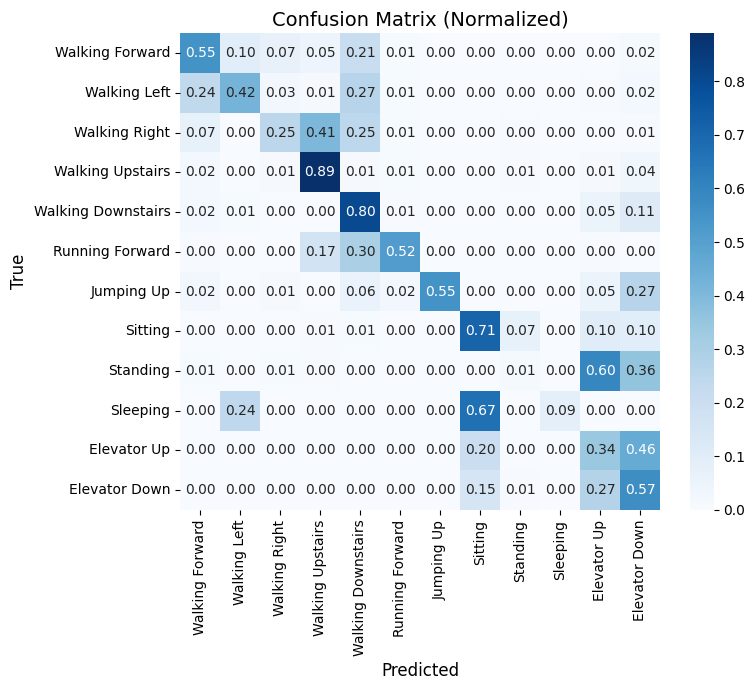

In [13]:
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
from collections import Counter
import scipy.io as scio # USC 함수에 필요
import sys # USC 함수에 필요

# --- 새 로더(USC)에 필요한 라이브러리 추가 ---
import requests
import zipfile
# ------------------------------------

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def plot_confusion_matrix(cm, labels):
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df = pd.DataFrame(cmn, index=labels, columns=labels)
    plt.figure(figsize=(8,7))
    sns.heatmap(df, annot=True, fmt='.2f', cmap='Blues', cbar=True)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix (Normalized)', fontsize=14)
    plt.tight_layout()
    plt.show()

class HARDataset(Dataset):
    def __init__(self, X, y, norm=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

        # 'norm=True'일 경우 (USC 로더가 Z_SCORE=False로 호출된 경우)
        if norm:
            # (N, C, L) 형태이므로 (0, 2) 축으로 계산
            self.mean = self.X.mean(axis=(0,2), keepdims=True)
            self.std = self.X.std(axis=(0,2), keepdims=True) + 1e-8
            self.X = (self.X - self.mean)/self.std
        else:
            # 'norm=False' (USC 로더가 Z_SCORE=True로 호출되어 이미 정규화됨)
            self.mean, self.std = None, None

    def set_stats(self, mean, std):
        # 이 함수는 norm=False일 때 외부 통계를 주입하기 위해 사용됨
        self.mean, self.std = mean, std
        self.X = (self.X - self.mean)/self.std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), int(self.y[i])

# -------------------------------------------------------------------
# ----------------- (시작) 'utils.py' 가상 구현 -----------------
# (제공된 USC.py가 의존하는 함수들을 재구현)
# -------------------------------------------------------------------

def download_dataset(dataset_name, file_url, dataset_dir):
    """
    USC-HAD 데이터셋을 다운로드하고 압축을 풉니다.
    (이전 스크립트의 'download_usc_had' 로직 기반)
    """
    save_dir = os.path.dirname(dataset_dir) # e.g., './'
    zip_path = os.path.join(save_dir, f"{dataset_name}.zip") # e.g., './USC-HAD.zip'
    data_path = dataset_dir # e.g., './USC-HAD'

    if os.path.exists(data_path):
        print(f"Dataset already found at: {data_path}")
        return data_path

    # save_dir가 비어있으면 (e.g., './USC-HAD') 현재 디렉토리로 설정
    if not save_dir:
        save_dir = '.'

    os.makedirs(save_dir, exist_ok=True)

    print(f"Downloading {dataset_name} from {file_url}...")
    r = requests.get(file_url, stream=True)
    if r.status_code != 200:
        raise RuntimeError(f"Failed to download: status {r.status_code}")

    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")

    print(f"Extracting to {save_dir}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(save_dir)
    os.remove(zip_path)
    print("Extraction complete.")

    return data_path

def sliding_window(content, WINDOW_SIZE, OVERLAP_RATE):
    """
    (N, C) 형태의 시계열 데이터에 슬라이딩 윈도우 적용
    (USC 함수의 요구사항에 맞게 구현)
    """
    # (L, C)
    stride = int(WINDOW_SIZE * (1.0 - OVERLAP_RATE))
    if stride <= 0:
        stride = 1 # 100% 오버랩 혹은 0 이하 스트라이드 방지

    windows = []
    start = 0
    while start + WINDOW_SIZE <= len(content):
        windows.append(content[start : start + WINDOW_SIZE, :])
        start += stride

    # (N_windows, L, C)
    return windows # 리스트로 반환 (USC 코드가 list.extend를 사용)

def z_score_standard(xtrain, xtest):
    """
    (N, L, C) 형태의 데이터에 대해 Z-score 정규화
    (USC 함수의 요구사항에 맞게 구현)
    """
    # (N, L, C) -> (0, 1) 축 (샘플, 시점)에 대해 평균/표준편차 계산
    xtrain_float = xtrain.astype(np.float32)
    xtest_float = xtest.astype(np.float32)

    mean = xtrain_float.mean(axis=(0, 1), keepdims=True)
    std = xtrain_float.std(axis=(0, 1), keepdims=True) + 1e-8

    xtrain_norm = (xtrain_float - mean) / std
    xtest_norm = (xtest_float - mean) / std

    return xtrain_norm, xtest_norm

def save_npy_data(dataset_name, root_dir, xtrain, xtest, ytrain, ytest):
    """
    (USC 함수의 요구사항에 맞게 구현)
    """
    print(f"\nSaving processed data to {root_dir}...")
    os.makedirs(root_dir, exist_ok=True)

    np.save(os.path.join(root_dir, f"{dataset_name}_xtrain.npy"), xtrain)
    np.save(os.path.join(root_dir, f"{dataset_name}_ytrain.npy"), ytrain)
    np.save(os.path.join(root_dir, f"{dataset_name}_xtest.npy"), xtest)
    np.save(os.path.join(root_dir, f"{dataset_name}_ytest.npy"), ytest)

    print("Save complete.")

# -------------------------------------------------------------------
# ------------------ (끝) 'utils.py' 가상 구현 ------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# ----------------- (시작) 사용자 제공 USC 로더 -----------------
# (이전 스크립트에서 가져온, 피험자 분리가 가능한 로더)
# -------------------------------------------------------------------

def USC(dataset_dir='./USC-HAD', WINDOW_SIZE=100, OVERLAP_RATE=0.1, SPLIT_RATE=(8, 2), VALIDATION_SUBJECTS={}, Z_SCORE=True, SAVE_PATH=os.path.abspath('./HAR-datasets')):
    '''
        dataset_dir: 源数据目录 : str
        WINDOW_SIZE: 滑窗大小 : int
        OVERLAP_RATE: 滑窗重叠率 : float in [0，1）
        SPLIT_RATE: 平均法分割验证集，表示训练集与验证集比例。优先级低于"VALIDATION_SUBJECTS": tuple
        VALIDATION_SUBJECTS: 留一法分割验证集，表示验证集所选取的Subjects : set
        Z_SCORE: 标准化 : bool
        SAVE_PATH: 预处理后npy数据保存目录 : str
    '''

    print("\n原数据分析：共12个活动，由14个受试者采集...\n")

    #  Subejct 1~14 검증
    if VALIDATION_SUBJECTS:
        print('\n---------- 采用【留一法】分割验证集，选取的subject为:%s ----------\n' % (VALIDATION_SUBJECTS))
        for each in VALIDATION_SUBJECTS:
            assert each in set([*range(1, 15)])
    else:
        print('\n---------- 采用【平均法】分割验证集，训练集与验证集样本数比为:%s ----------\n' % (str(SPLIT_RATE)))

    # (구현된 utils 함수 호출)
    download_dataset(
        dataset_name='USC-HAD',
        file_url='https://sipi.usc.edu/had/USC-HAD.zip',
        dataset_dir=dataset_dir
    )

    xtrain, xtest, ytrain, ytest = [], [], [], [] # 최종 데이터

    # 원본 CWD 저장
    original_cwd = os.getcwd()

    try:
        subject_list = os.listdir(dataset_dir)
        os.chdir(dataset_dir)
        print('Loading subject data')
        for subject in subject_list:
            if not os.path.isdir(subject):
                continue

            # 'Subject1'에서 숫자 1 추출
            subject_id_match = re.findall(r'(\d+)', subject)
            if not subject_id_match:
                continue
            subject_id = int(subject_id_match[0])

            print('       current subject: 【%d】'%(subject_id), end='')
            print('    ----    Validation Data' if subject_id in VALIDATION_SUBJECTS else '')

            mat_list = os.listdir(subject)
            os.chdir(subject)
            for mat in mat_list:
                if not mat.endswith('.mat'):
                    continue

                # 'a1t1.mat'에서 '1' 추출
                label_id_match = re.findall(r'a(\d+)', mat)
                if not label_id_match:
                    continue

                label_id = int(label_id_match[0]) - 1 # 0-11 인덱스

                content = scio.loadmat(mat)['sensor_readings']

                # (구현된 utils 함수 호출)
                cur_data = sliding_window(content, WINDOW_SIZE, OVERLAP_RATE)

                # 两种分割验证集的方法 [留一法 or 平均法]
                if VALIDATION_SUBJECTS: # 留一法 (이 방식을 사용)
                    if subject_id not in VALIDATION_SUBJECTS: # 훈련 데이터
                        xtrain.extend(cur_data)
                        ytrain.extend([label_id] * len(cur_data))
                    else: # 테스트 데이터
                        xtest.extend(cur_data)
                        ytest.extend([label_id] * len(cur_data))
                else: # 평균법
                    trainlen = int(len(cur_data) * SPLIT_RATE[0] / sum(SPLIT_RATE))
                    xtrain.extend(cur_data[:trainlen])
                    xtest.extend(cur_data[trainlen:])
                    ytrain.extend([label_id] * trainlen)
                    ytest.extend([label_id] * (len(cur_data) - trainlen))

            os.chdir('../')
    except Exception as e:
        print(f"Error during data loading: {e}")
    finally:
        os.chdir(original_cwd) # 예외 발생 시에도 원래 디렉토리로 복귀

    xtrain, xtest, ytrain, ytest = np.array(xtrain), np.array(xtest), np.array(ytrain), np.array(ytest)

    # 데이터 로딩 확인
    if xtrain.size == 0 or ytrain.size == 0:
        print("Warning: Training data is empty. Check path and VALIDATION_SUBJECTS.")
    if xtest.size == 0 or ytest.size == 0:
         print("Warning: Test data is empty. Check path and VALIDATION_SUBJECTS.")


    if Z_SCORE and xtrain.size > 0: # 훈련 데이터가 있을 때만 정규화
        # (구현된 utils 함수 호출)
        xtrain, xtest = z_score_standard(xtrain=xtrain, xtest=xtest)

    print('\n---------------------------------------------------------------------------------------------------------------------\n')
    print('xtrain shape (N, L, C): %s\nxtest shape (N, L, C): %s\nytrain shape: %s\nytest shape: %s'%(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape))

    if SAVE_PATH: # 数组数据保存目录
        # (구현된 utils 함수 호출)
        save_npy_data(
            dataset_name='USC_HAD',
            root_dir=SAVE_PATH,
            xtrain=xtrain,
            xtest=xtest,
            ytrain=ytrain,
            ytest=ytest
        )

    return xtrain, xtest, ytrain, ytest

# -------------------------------------------------------------------
# ------------------ (끝) 사용자 제공 USC 로더 ------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# --------------------- (시작) ResNet 모델 정의 ---------------------
# (이 부분은 이전과 동일)
# -------------------------------------------------------------------

class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.act = nn.GELU()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.act(out)
        return out

class ResNet1DEncoder(nn.Module):
    def __init__(self, in_channels=9, embed_dim=128):
        super().__init__()

        self.in_channels = 32

        self.stage0 = nn.Sequential(
            nn.Conv1d(in_channels, self.in_channels, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm1d(self.in_channels),
            nn.GELU()
        )

        self.stage1 = self._make_layer(BasicBlock1D, 64, blocks=1, stride=2)
        self.stage2 = self._make_layer(BasicBlock1D, 128, blocks=1, stride=2)
        self.stage3 = self._make_layer(BasicBlock1D, embed_dim, blocks=1, stride=2)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stage0(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        return x

class SupervisedBaseline(nn.Module):
    def __init__(self, in_channels=9, embed_dim=128, num_classes=6):
        super().__init__()
        self.encoder = ResNet1DEncoder(in_channels=in_channels, embed_dim=embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def extract_features(self, x):
        return self.encoder(x)

    def forward(self, x):
        features = self.extract_features(x)
        return self.classifier(features)

# -------------------------------------------------------------------
# ---------------------- (끝) ResNet 모델 정의 ----------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# ------------------ (시작) 학습/테스트 함수 (동일) -----------------
# -------------------------------------------------------------------

def train_supervised(model, train_loader, optimizer, criterion, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)
            total_correct += (logits.argmax(1) == y_batch).sum().item()
            total_samples += x_batch.size(0)

        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

def test_supervised(model, test_loader, device, num_classes=6):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(y_batch.cpu().numpy())

    if not all_trues:
        return 0, 0, 0, 0, np.zeros((num_classes, num_classes))

    acc = accuracy_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds, average='macro', zero_division=0)
    prec = precision_score(all_trues, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_trues, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_trues, all_preds, labels=range(num_classes))
    return acc, f1, prec, rec, cm

# -------------------------------------------------------------------
# ------------------- (끝) 학습/테스트 함수 (동일) ------------------
# -------------------------------------------------------------------


if __name__ == '__main__':
    # USC.py 스크립트가 os.chdir을 사용하므로, 스크립트의 기본 경로를 설정
    # (일반적으로 이 파일이 위치한 디렉토리)
    script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
    os.chdir(script_dir)

    set_seed(42)
    device = 'cuda'
    print(f"Device: {device}\n")

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    # 레이블 리스트 정의 (USC-HAD 12개 활동, 0~11 인덱스)
    labels_list = [
        "Walking Forward", "Walking Left", "Walking Right", "Walking Upstairs",
        "Walking Downstairs", "Running Forward", "Jumping Up", "Sitting",
        "Standing", "Sleeping", "Elevator Up", "Elevator Down"
    ]

    # --- (시작) 데이터 로딩 로직 (USC 함수 사용) ---
    print("=" * 60)
    print("LOADING USC-HAD DATASET (using USC function)")
    print("=" * 60)

    # USC 함수 호출
    # VALIDATION_SUBJECTS={13, 14}: 피험자 13, 14를 테스트용으로 분리 (핵심 요구사항)
    # WINDOW_SIZE=100, OVERLAP_RATE=0.5: 100 윈도우, 50 스트라이드 (이전 스크립트와 동일)
    # Z_SCORE=True: 로더가 Z-score 정규화 수행
    # SAVE_PATH=None: .npy 파일 저장 안 함
    X_train_raw, X_test_raw, y_train, y_test = USC(
        dataset_dir=os.path.join(script_dir, 'USC-HAD'), # 스크립트 기준 상대 경로
        WINDOW_SIZE=100,
        OVERLAP_RATE=0.5,
        VALIDATION_SUBJECTS={13, 14},
        Z_SCORE=True,
        SAVE_PATH=None
    )

    if X_train_raw.size == 0 or X_test_raw.size == 0:
        raise ValueError(f"데이터 로딩에 실패했습니다. './USC-HAD' 경로를 확인하세요.")

    # 데이터 형태 변환: (N, L, C) -> (N, C, L)
    # 예: (N, 100, 6) -> (N, 6, 100)
    X_train = np.transpose(X_train_raw, (0, 2, 1))
    X_test = np.transpose(X_test_raw, (0, 2, 1))

    # --- (끝) 데이터 로딩 로직 ---


    print(f"\nLoaded Train data shape (N, C, L): {X_train.shape}")
    print(f"Loaded Test data shape (N, C, L): {X_test.shape}")
    print(f"Labels: {labels_list}")

    # 모델 파라미터 설정 (로드된 데이터 기준)
    INPUT_CHANNELS = X_train.shape[1] # 6
    INPUT_LENGTH = X_train.shape[2]   # 100
    TOTAL_CLASSES = len(labels_list)  # 12

    print(f"Input Channels: {INPUT_CHANNELS}, Input Length: {INPUT_LENGTH}, Total Classes: {TOTAL_CLASSES}")

    print(f"\nTrain samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    # 데이터셋 생성 (Z_SCORE=True로 로드했으므로 norm=False 전달)
    train_dataset_sup = HARDataset(X_train, y_train, norm=False)
    train_loader_sup = DataLoader(train_dataset_sup, batch_size=256, shuffle=True)

    test_dataset_sup = HARDataset(X_test, y_test, norm=False)
    test_loader_sup = DataLoader(test_dataset_sup, batch_size=512, shuffle=False)

    print("\n" + "=" * 80)
    print("PART 1: SUPERVISED BASELINE (ResNet1DEncoder + Classifier)")
    print("=" * 80)

    supervised_model = SupervisedBaseline(
        in_channels=INPUT_CHANNELS,
        embed_dim=128,
        num_classes=TOTAL_CLASSES
    ).to(device)

    optimizer_sup = torch.optim.Adam(supervised_model.parameters(), lr=0.001)
    criterion_sup = nn.CrossEntropyLoss()

    print("--- Training Supervised Baseline ---")
    train_supervised(supervised_model, train_loader_sup, optimizer_sup, criterion_sup, epochs=100, device=device)

    print("\n--- Testing Supervised Baseline (Clean) ---")
    acc_s, f1_s, prec_s, rec_s, cm_s = test_supervised(supervised_model, test_loader_sup, device, num_classes=TOTAL_CLASSES)

    print("\n" + "=" * 80)
    print("===== FINAL RESULTS =====")
    print("=" * 80)

    print(f"Supervised Clean | Accuracy: {acc_s:.4f}")
    print(f"Supervised Clean | F1-Score: {f1_s:.4f}")

    print("\n--- Confusion Matrix (Raw) ---")
    print(cm_s)

    print("\n--- Plotting Normalized Confusion Matrix ---")
    plot_confusion_matrix(cm_s, labels_list)

Device: cuda

LOADING USC-HAD DATASET (80/20 Split)

原数据分析：共12个活动，由14个受试者采集...


---------- 采用【平均法】分割验证集，训练集与验证集样本数比为:(8, 2) ----------

Dataset already found at: /content/drive/MyDrive/HAR_Dataset/USC/Subject2/USC-HAD
Loading subject data
       current subject: 【1】
       current subject: 【10】
       current subject: 【11】
       current subject: 【12】
       current subject: 【13】
       current subject: 【14】
       current subject: 【2】
       current subject: 【3】
       current subject: 【4】
       current subject: 【5】
       current subject: 【6】
       current subject: 【7】
       current subject: 【8】
       current subject: 【9】

---------------------------------------------------------------------------------------------------------------------

xtrain shape (N, L, C): (43959, 100, 6)
xtest shape (N, L, C): (11362, 100, 6)
ytrain shape: (43959,)
ytest shape: (11362,)

Loaded Train data shape (N, C, L): (43959, 6, 100)
Loaded Test data shape (N, C, L): (11362, 6, 100)
Labels: ['Walking

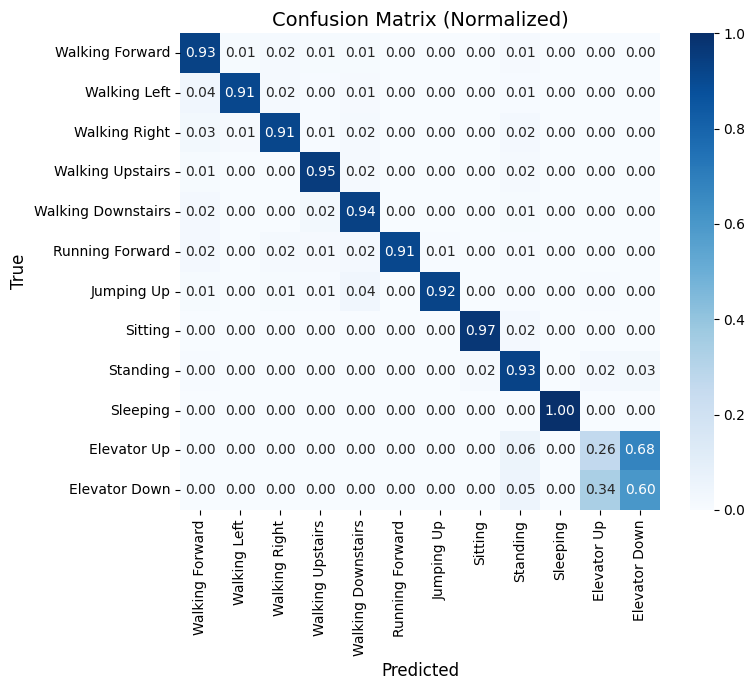

In [14]:
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re
from collections import Counter
import scipy.io as scio # USC 함수에 필요
import sys # USC 함수에 필요

# --- 새 로더(USC)에 필요한 라이브러리 추가 ---
import requests
import zipfile
# ------------------------------------

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def plot_confusion_matrix(cm, labels):
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df = pd.DataFrame(cmn, index=labels, columns=labels)
    plt.figure(figsize=(8,7))
    sns.heatmap(df, annot=True, fmt='.2f', cmap='Blues', cbar=True)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix (Normalized)', fontsize=14)
    plt.tight_layout()
    plt.show()

class HARDataset(Dataset):
    def __init__(self, X, y, norm=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)

        if norm:
            self.mean = self.X.mean(axis=(0,2), keepdims=True)
            self.std = self.X.std(axis=(0,2), keepdims=True) + 1e-8
            self.X = (self.X - self.mean)/self.std
        else:
            self.mean, self.std = None, None

    def set_stats(self, mean, std):
        self.mean, self.std = mean, std
        self.X = (self.X - self.mean)/self.std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), int(self.y[i])

# -------------------------------------------------------------------
# ----------------- (시작) 'utils.py' 가상 구현 -----------------
# -------------------------------------------------------------------

def download_dataset(dataset_name, file_url, dataset_dir):
    save_dir = os.path.dirname(dataset_dir)
    zip_path = os.path.join(save_dir, f"{dataset_name}.zip")
    data_path = dataset_dir

    if os.path.exists(data_path):
        print(f"Dataset already found at: {data_path}")
        return data_path

    if not save_dir:
        save_dir = '.'

    os.makedirs(save_dir, exist_ok=True)

    print(f"Downloading {dataset_name} from {file_url}...")
    r = requests.get(file_url, stream=True)
    if r.status_code != 200:
        raise RuntimeError(f"Failed to download: status {r.status_code}")

    with open(zip_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")

    print(f"Extracting to {save_dir}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(save_dir)
    os.remove(zip_path)
    print("Extraction complete.")

    return data_path

def sliding_window(content, WINDOW_SIZE, OVERLAP_RATE):
    stride = int(WINDOW_SIZE * (1.0 - OVERLAP_RATE))
    if stride <= 0:
        stride = 1

    windows = []
    start = 0
    while start + WINDOW_SIZE <= len(content):
        windows.append(content[start : start + WINDOW_SIZE, :])
        start += stride

    return windows

def z_score_standard(xtrain, xtest):
    xtrain_float = xtrain.astype(np.float32)
    xtest_float = xtest.astype(np.float32)

    mean = xtrain_float.mean(axis=(0, 1), keepdims=True)
    std = xtrain_float.std(axis=(0, 1), keepdims=True) + 1e-8

    xtrain_norm = (xtrain_float - mean) / std
    xtest_norm = (xtest_float - mean) / std

    return xtrain_norm, xtest_norm

def save_npy_data(dataset_name, root_dir, xtrain, xtest, ytrain, ytest):
    print(f"\nSaving processed data to {root_dir}...")
    os.makedirs(root_dir, exist_ok=True)

    np.save(os.path.join(root_dir, f"{dataset_name}_xtrain.npy"), xtrain)
    np.save(os.path.join(root_dir, f"{dataset_name}_ytrain.npy"), ytrain)
    np.save(os.path.join(root_dir, f"{dataset_name}_xtest.npy"), xtest)
    np.save(os.path.join(root_dir, f"{dataset_name}_ytest.npy"), ytest)

    print("Save complete.")

# -------------------------------------------------------------------
# ------------------ (끝) 'utils.py' 가상 구현 ------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# ----------------- (시작) 사용자 제공 USC 로더 -----------------
# -------------------------------------------------------------------

def USC(dataset_dir='./USC-HAD', WINDOW_SIZE=100, OVERLAP_RATE=0.1, SPLIT_RATE=(8, 2), VALIDATION_SUBJECTS={}, Z_SCORE=True, SAVE_PATH=os.path.abspath('./HAR-datasets')):

    print("\n原数据分析：共12个活动，由14个受试者采集...\n")

    if VALIDATION_SUBJECTS:
        print('\n---------- 采用【留一法】分割验证集，选取的subject为:%s ----------\n' % (VALIDATION_SUBJECTS))
        for each in VALIDATION_SUBJECTS:
            assert each in set([*range(1, 15)])
    else:
        # 이 분기(평균법)가 실행됩니다.
        print('\n---------- 采用【平均法】分割验证集，训练集与验证集样本数比为:%s ----------\n' % (str(SPLIT_RATE)))

    download_dataset(
        dataset_name='USC-HAD',
        file_url='https://sipi.usc.edu/had/USC-HAD.zip',
        dataset_dir=dataset_dir
    )

    xtrain, xtest, ytrain, ytest = [], [], [], []

    original_cwd = os.getcwd()

    try:
        subject_list = os.listdir(dataset_dir)
        os.chdir(dataset_dir)
        print('Loading subject data')
        for subject in subject_list:
            if not os.path.isdir(subject):
                continue

            subject_id_match = re.findall(r'(\d+)', subject)
            if not subject_id_match:
                continue
            subject_id = int(subject_id_match[0])

            print('       current subject: 【%d】'%(subject_id), end='')
            # VALIDATION_SUBJECTS가 비어있으므로 'Validation Data'가 출력되지 않습니다.
            print('    ----    Validation Data' if subject_id in VALIDATION_SUBJECTS else '')

            mat_list = os.listdir(subject)
            os.chdir(subject)
            for mat in mat_list:
                if not mat.endswith('.mat'):
                    continue

                label_id_match = re.findall(r'a(\d+)', mat)
                if not label_id_match:
                    continue

                label_id = int(label_id_match[0]) - 1 # 0-11 인덱스
                content = scio.loadmat(mat)['sensor_readings']
                cur_data = sliding_window(content, WINDOW_SIZE, OVERLAP_RATE)

                if VALIDATION_SUBJECTS: # (False)
                    if subject_id not in VALIDATION_SUBJECTS:
                        xtrain.extend(cur_data)
                        ytrain.extend([label_id] * len(cur_data))
                    else:
                        xtest.extend(cur_data)
                        ytest.extend([label_id] * len(cur_data))
                else: # (True) "평균법" (8:2 분할)
                    trainlen = int(len(cur_data) * SPLIT_RATE[0] / sum(SPLIT_RATE))
                    testlen = len(cur_data) - trainlen
                    xtrain.extend(cur_data[:trainlen])
                    xtest.extend(cur_data[trainlen:])
                    ytrain.extend([label_id] * trainlen)
                    ytest.extend([label_id] * testlen)

            os.chdir('../')
    except Exception as e:
        print(f"Error during data loading: {e}")
    finally:
        os.chdir(original_cwd)

    xtrain, xtest, ytrain, ytest = np.array(xtrain), np.array(xtest), np.array(ytrain), np.array(ytest)

    if xtrain.size == 0 or ytrain.size == 0:
        print("Warning: Training data is empty.")
    if xtest.size == 0 or ytest.size == 0:
         print("Warning: Test data is empty.")

    if Z_SCORE and xtrain.size > 0:
        xtrain, xtest = z_score_standard(xtrain=xtrain, xtest=xtest)

    print('\n---------------------------------------------------------------------------------------------------------------------\n')
    print('xtrain shape (N, L, C): %s\nxtest shape (N, L, C): %s\nytrain shape: %s\nytest shape: %s'%(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape))

    if SAVE_PATH:
        save_npy_data(
            dataset_name='USC_HAD',
            root_dir=SAVE_PATH,
            xtrain=xtrain,
            xtest=xtest,
            ytrain=ytrain,
            ytest=ytest
        )

    return xtrain, xtest, ytrain, ytest

# -------------------------------------------------------------------
# ------------------ (끝) 사용자 제공 USC 로더 ------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# --------------------- (시작) ResNet 모델 정의 ---------------------
# (이전과 동일)
# -------------------------------------------------------------------

class BasicBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.act = nn.GELU()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.act(out)
        return out

class ResNet1DEncoder(nn.Module):
    def __init__(self, in_channels=9, embed_dim=128):
        super().__init__()
        self.in_channels = 32
        self.stage0 = nn.Sequential(
            nn.Conv1d(in_channels, self.in_channels, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm1d(self.in_channels),
            nn.GELU()
        )
        self.stage1 = self._make_layer(BasicBlock1D, 64, blocks=1, stride=2)
        self.stage2 = self._make_layer(BasicBlock1D, 128, blocks=1, stride=2)
        self.stage3 = self._make_layer(BasicBlock1D, embed_dim, blocks=1, stride=2)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stage0(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        return x

class SupervisedBaseline(nn.Module):
    def __init__(self, in_channels=9, embed_dim=128, num_classes=6):
        super().__init__()
        self.encoder = ResNet1DEncoder(in_channels=in_channels, embed_dim=embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def extract_features(self, x):
        return self.encoder(x)

    def forward(self, x):
        features = self.extract_features(x)
        return self.classifier(features)

# -------------------------------------------------------------------
# ---------------------- (끝) ResNet 모델 정의 ----------------------
# -------------------------------------------------------------------


# -------------------------------------------------------------------
# ------------------ (시작) 학습/테스트 함수 (동일) -----------------
# -------------------------------------------------------------------

def train_supervised(model, train_loader, optimizer, criterion, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x_batch.size(0)
            total_correct += (logits.argmax(1) == y_batch).sum().item()
            total_samples += x_batch.size(0)
        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

def test_supervised(model, test_loader, device, num_classes=6):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(y_batch.cpu().numpy())
    if not all_trues:
        return 0, 0, 0, 0, np.zeros((num_classes, num_classes))
    acc = accuracy_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds, average='macro', zero_division=0)
    prec = precision_score(all_trues, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_trues, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_trues, all_preds, labels=range(num_classes))
    return acc, f1, prec, rec, cm

# -------------------------------------------------------------------
# ------------------- (끝) 학습/테스트 함수 (동일) ------------------
# -------------------------------------------------------------------


if __name__ == '__main__':
    script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
    os.chdir(script_dir)

    set_seed(42)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}\n")

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    labels_list = [
        "Walking Forward", "Walking Left", "Walking Right", "Walking Upstairs",
        "Walking Downstairs", "Running Forward", "Jumping Up", "Sitting",
        "Standing", "Sleeping", "Elevator Up", "Elevator Down"
    ]

    # --- (시작) 데이터 로딩 로직 변경 (8:2 분할) ---
    print("=" * 60)
    print("LOADING USC-HAD DATASET (80/20 Split)")
    print("=" * 60)

    # *** 변경된 부분 ***
    # VALIDATION_SUBJECTS={}: 빈 값으로 설정하여 "평균법" (8:2) 분할 사용
    # SPLIT_RATE=(8, 2): 80% 훈련, 20% 테스트
    X_train_raw, X_test_raw, y_train, y_test = USC(
        dataset_dir=os.path.join(script_dir, 'USC-HAD'),
        WINDOW_SIZE=100,
        OVERLAP_RATE=0.5,
        VALIDATION_SUBJECTS={}, # <- 이 부분을 빈 값으로 변경
        SPLIT_RATE=(8, 2),    # <- 8:2 비율 명시
        Z_SCORE=True,
        SAVE_PATH=None
    )

    if X_train_raw.size == 0 or X_test_raw.size == 0:
        raise ValueError(f"데이터 로딩에 실패했습니다. './USC-HAD' 경로를 확인하세요.")

    # 데이터 형태 변환: (N, L, C) -> (N, C, L)
    X_train = np.transpose(X_train_raw, (0, 2, 1))
    X_test = np.transpose(X_test_raw, (0, 2, 1))

    # --- (끝) 데이터 로딩 로직 변경 ---


    print(f"\nLoaded Train data shape (N, C, L): {X_train.shape}")
    print(f"Loaded Test data shape (N, C, L): {X_test.shape}")
    print(f"Labels: {labels_list}")

    INPUT_CHANNELS = X_train.shape[1]
    INPUT_LENGTH = X_train.shape[2]
    TOTAL_CLASSES = len(labels_list)

    print(f"Input Channels: {INPUT_CHANNELS}, Input Length: {INPUT_LENGTH}, Total Classes: {TOTAL_CLASSES}")

    print(f"\nTrain samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    # 데이터셋 생성 (Z_SCORE=True로 로드했으므로 norm=False)
    train_dataset_sup = HARDataset(X_train, y_train, norm=False)
    train_loader_sup = DataLoader(train_dataset_sup, batch_size=256, shuffle=True)

    test_dataset_sup = HARDataset(X_test, y_test, norm=False)
    test_loader_sup = DataLoader(test_dataset_sup, batch_size=512, shuffle=False)

    print("\n" + "=" * 80)
    print("PART 1: SUPERVISED BASELINE (ResNet1DEncoder + Classifier)")
    print("=" * 80)

    supervised_model = SupervisedBaseline(
        in_channels=INPUT_CHANNELS,
        embed_dim=128,
        num_classes=TOTAL_CLASSES
    ).to(device)

    optimizer_sup = torch.optim.Adam(supervised_model.parameters(), lr=0.001)
    criterion_sup = nn.CrossEntropyLoss()

    print("--- Training Supervised Baseline ---")
    train_supervised(supervised_model, train_loader_sup, optimizer_sup, criterion_sup, epochs=100, device=device)

    print("\n--- Testing Supervised Baseline (Clean) ---")
    acc_s, f1_s, prec_s, rec_s, cm_s = test_supervised(supervised_model, test_loader_sup, device, num_classes=TOTAL_CLASSES)

    print("\n" + "=" * 80)
    print("===== FINAL RESULTS =====")
    print("=" * 80)

    print(f"Supervised Clean | Accuracy: {acc_s:.4f}")
    print(f"Supervised Clean | F1-Score: {f1_s:.4f}")

    print("\n--- Confusion Matrix (Raw) ---")
    print(cm_s)

    print("\n--- Plotting Normalized Confusion Matrix ---")
    plot_confusion_matrix(cm_s, labels_list)

### 결론 : LSSO의 문제였다!!!!!!!!